Title

Description

Importing packages.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from sklearn.model_selection import GridSearchCV
%matplotlib inline

Importing data.

In [6]:
# I use the ipywidgets library to allow for a nice menu to select the dataset.
w_data = widgets.Dropdown(
    options=['Full', 'Spatio-temporal', 'Meteorological', 'Topological'],
    value='Full',
    description='Dataset selection:',
)

print("Choose the dataset you want to use below and you can run the next sections with it.")
display(w_data)

Choose the dataset you want to use below and you can run the next sections with it.


Dropdown(description='Dataset selection:', options=('Full', 'Spatio-temporal', 'Meteorological', 'Topological'…

Import the X and y datasets. If you want to change the dataset you're using, change the selection from the dropdown
above and rerun this cell.

In [14]:
if w_data.value == 'Full':
    X = pd.read_csv(r"data/data_Full_X.csv", index_col=0)
    y = pd.read_csv(r"data/data_Full_y.csv", index_col=0)

elif w_data.value == 'Spatio-temporal':
    X = pd.read_csv(r"data/data_SPT_X.csv", index_col=0)
    y = pd.read_csv(r"data/data_SPT_y.csv", index_col=0)

elif w_data.value == 'Meteorological':
    X = pd.read_csv(r"data/data_M_X.csv", index_col=0)
    y = pd.read_csv(r"data/data_M_y.csv", index_col=0)

elif w_data.value == 'Topological':
    X = pd.read_csv(r"data/data_T_X.csv", index_col=0)
    y = pd.read_csv(r"data/data_T_y.csv", index_col=0)

else: raise Exception("It seems that something went wrong. The widget gave an unexpected output value. "
                      "Values should be one of: ['Full', 'Spatio-temporal', 'Meteorological', 'Topological'].")

print("Features:", list(X.columns))
# print(y.sample(5))

Features: ['elevation', 'Veg Broadleaf Forest', 'Veg Desert', 'Veg Grassland', 'Veg Needleleaf Forest', 'Veg Rock', 'Veg Shrubland']


Train-test split the dataset.

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

print(X_train.shape)
print(y_train.shape, "\n")

print(X_test.shape)
print(y_test.shape)

(33522, 7)
(33522, 1) 

(3725, 7)
(3725, 1)


Let's check the balance of the target features.

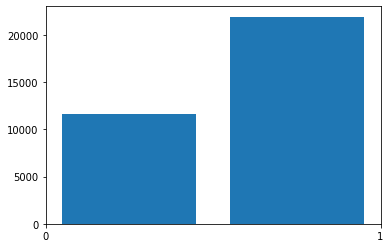

In [12]:
plt.hist(y_train, bins=2, rwidth=0.8)
plt.xticks((0,1))
if w_data.value == 'Full':
    plt.savefig(r"figures/hist_y_unbalanced.png")

In order to fix the distribution of the data when training, we want to change it (in the training set only though).

To do this I used a simple random undersample of the training data. I used the imblearn implementation.

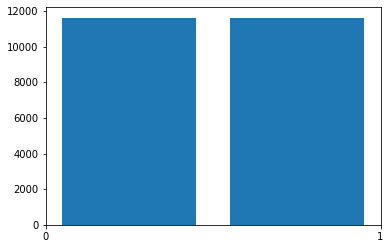

In [16]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()
X_train, y_train = rus.fit_resample(X_train, y_train)
y_train = y_train.values.ravel()

# print(X_train.shape)
# print(y_train.shape)

plt.hist(y_train, bins=2, rwidth=0.8)
plt.xticks((0,1))
if w_data.value == 'Full':
    plt.savefig(r"figures/hist_y_balanced.png")

Make a correlation matrix of the features.

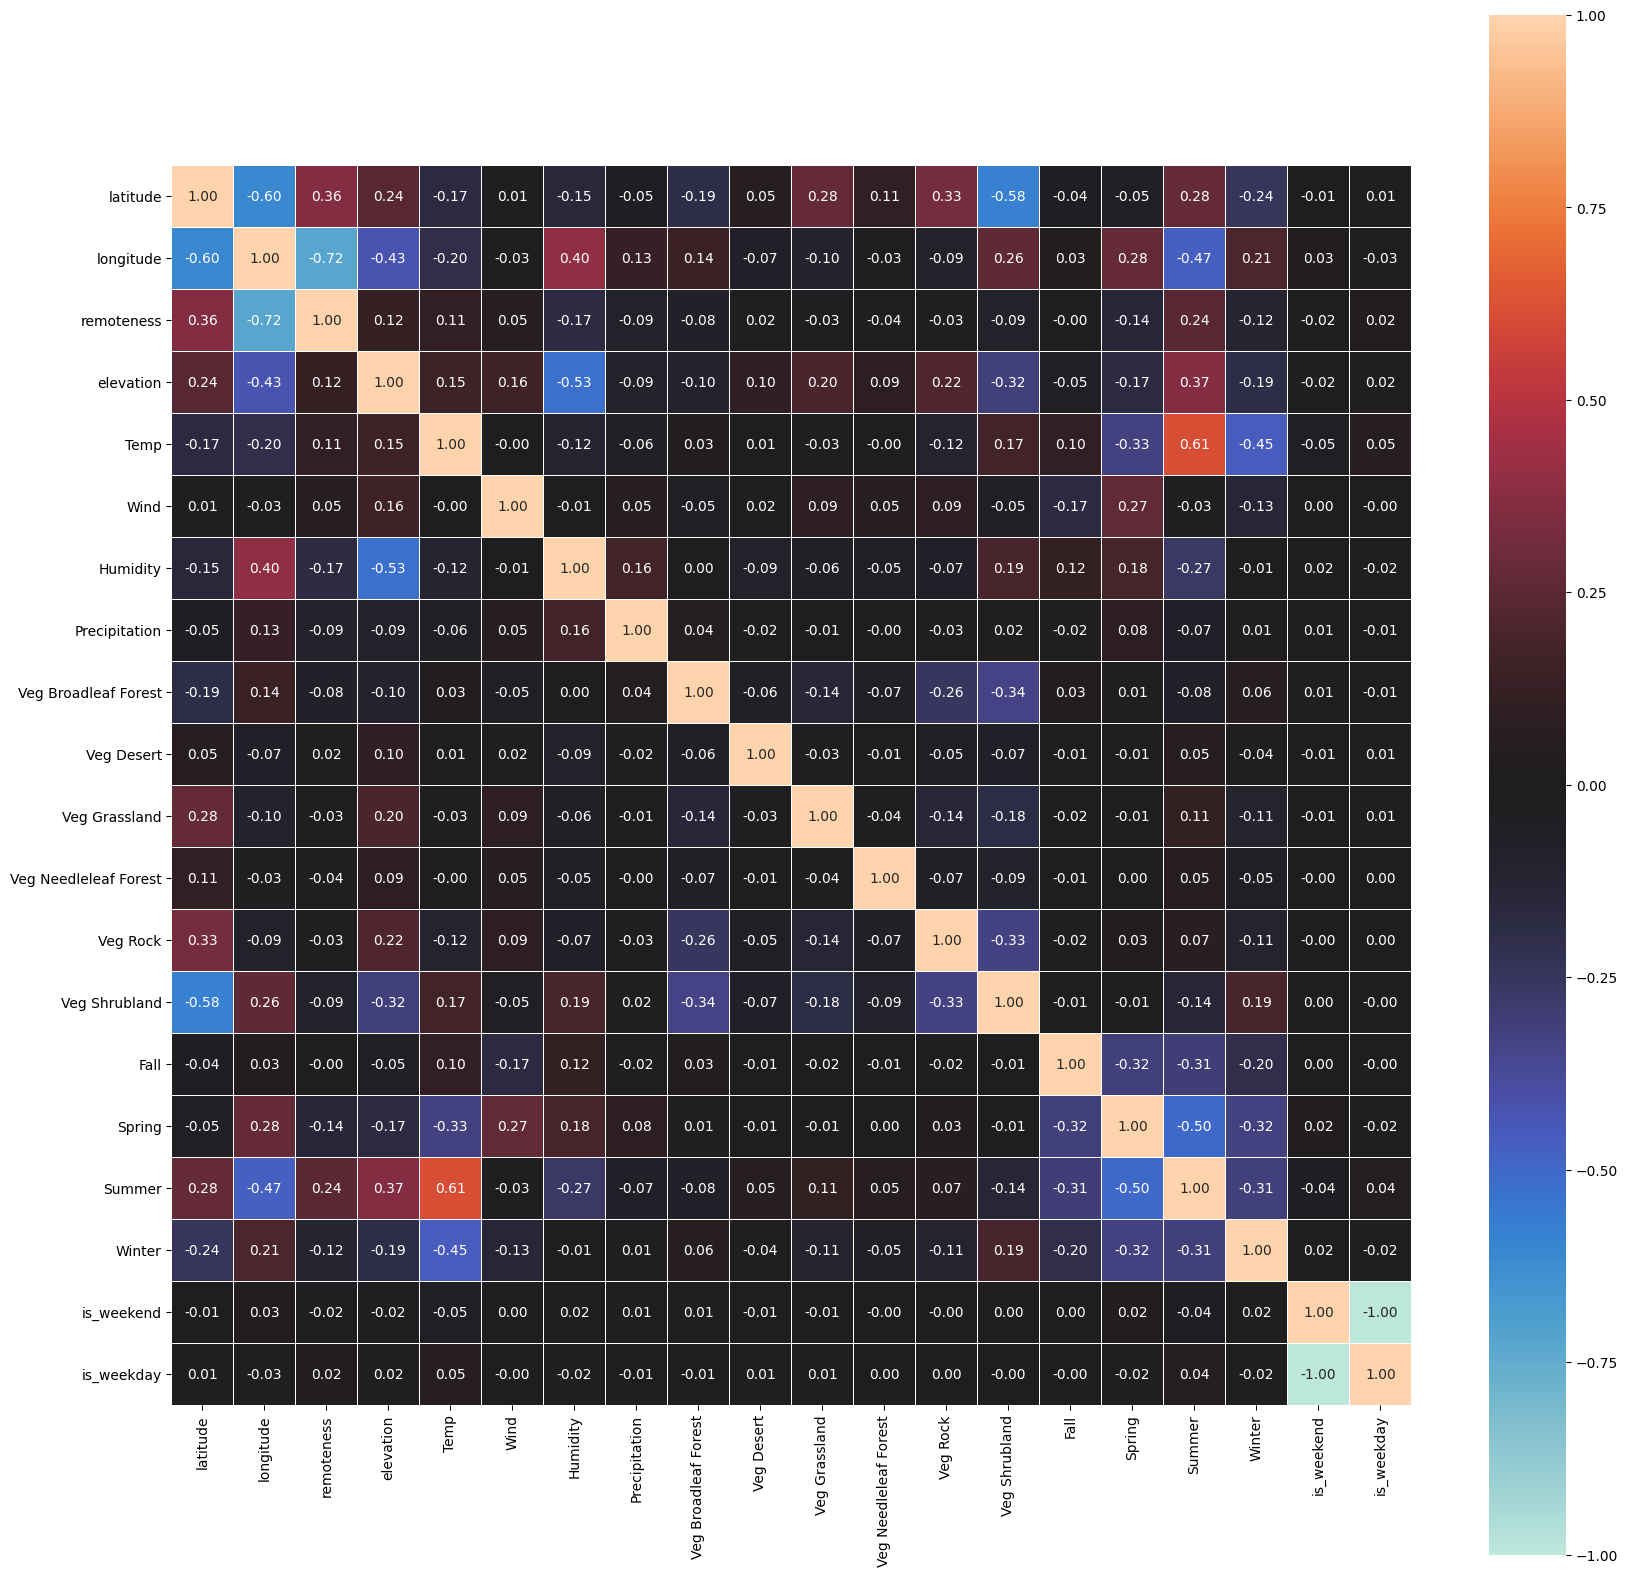

In [36]:
import seaborn as sn

plt.rcParams['figure.figsize'] = [20, 20]

corrMatrix = X_train.corr()
sn.heatmap(corrMatrix, vmax=1.0,  center=0, fmt='.2f',
            square=True, linewidths=.5, annot=True)
plt.savefig(r"figures/corrMatrix.png", transparent=True)

plt.rcParams.update(plt.rcParamsDefault)

Training models, each in a cell (?)

* Dummy classifier
* K-Nearest Neighbour (KNN)
* Naïve Bayes (NB)
* Support Vector Machine (SVM)
* Decision Tree (DT)
* Random Forest (RF)
* Gradient Boosted Trees (GBT)
* Multi-Layered Perceptron (MLP)

Evaluation with confusion matrix, F1 score, etc

### Dummy classifier

In [19]:
from sklearn.dummy import DummyClassifier

param_grid = {'strategy': ['stratified']}

grid_searchDummy = GridSearchCV(DummyClassifier(), param_grid, cv=10, n_jobs=-1)
grid_searchDummy.fit(X_train, y_train)

training_accuracy = grid_searchDummy.score(X_train, y_train)
test_accuracy = grid_searchDummy.score(X_test, y_test)

print("Test set score: {}".format(grid_searchDummy.score(X_test, y_test)))

y_true, y_pred = y_test , grid_searchDummy.predict(X_test)
from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))

Test set score: 0.5030872483221477
Results on the test set:
              precision    recall  f1-score   support

           0       0.34      0.47      0.39      1291
           1       0.65      0.51      0.57      2434

    accuracy                           0.50      3725
   macro avg       0.49      0.49      0.48      3725
weighted avg       0.54      0.50      0.51      3725



### KNN

In [20]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = {'n_neighbors': range(2, 30, 2), 'weights': ['uniform', 'distance']}

grid_searchKNN = GridSearchCV(KNeighborsClassifier(), param_grid, cv=10, n_jobs=-1)
grid_searchKNN.fit(X_train, y_train)

print("Test set score: {}".format(grid_searchKNN.score(X_test, y_test)))

y_true, y_pred = y_test , grid_searchKNN.predict(X_test)
from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))

Test set score: 0.6056375838926175
Results on the test set:
              precision    recall  f1-score   support

           0       0.45      0.61      0.52      1291
           1       0.75      0.60      0.67      2434

    accuracy                           0.61      3725
   macro avg       0.60      0.61      0.59      3725
weighted avg       0.64      0.61      0.61      3725



### Naive Bayes

In [21]:
from sklearn.naive_bayes import GaussianNB

param_grid = {}

grid_searchGNB = GridSearchCV(GaussianNB(), param_grid, cv=10, n_jobs=-1)
grid_searchGNB.fit(X_train, y_train)

print("Test set score: {}".format(grid_searchGNB.score(X_test, y_test)))

y_true, y_pred = y_test , grid_searchGNB.predict(X_test)
from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))

Test set score: 0.6703355704697986
Results on the test set:
              precision    recall  f1-score   support

           0       0.54      0.34      0.41      1291
           1       0.71      0.85      0.77      2434

    accuracy                           0.67      3725
   macro avg       0.62      0.59      0.59      3725
weighted avg       0.65      0.67      0.65      3725



### Support Vector Machine

In [32]:
from sklearn.svm import SVC

param_grid = {'kernel': ['poly', 'rbf', 'sigmoid'],'C': [0.01, 0.1, 0.25, 0.5, 1, 2]}

grid_searchSVC = GridSearchCV(SVC(), param_grid, cv=10, n_jobs=-1)
grid_searchSVC.fit(X_train, y_train)

print("Test set score: {}".format(grid_searchSVC.score(X_test, y_test)))

y_true, y_pred = y_test , grid_searchSVC.predict(X_test)
from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))

Test set score: 0.6893959731543624
Results on the test set:
              precision    recall  f1-score   support

           0       0.58      0.39      0.47      1291
           1       0.72      0.85      0.78      2434

    accuracy                           0.69      3725
   macro avg       0.65      0.62      0.62      3725
weighted avg       0.67      0.69      0.67      3725



### Decision Tree

In [33]:
from sklearn.tree import DecisionTreeClassifier

param_grid = {'max_depth': [2, 4, 16, 64, 128, 256, None], 'criterion': ['gini', 'entropy']}

grid_searchDT = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=10, n_jobs=-1)
grid_searchDT.fit(X_train, y_train)

print("Test set score: {}".format(grid_searchDT.score(X_test, y_test)))

y_true, y_pred = y_test , grid_searchDT.predict(X_test)
from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))

Test set score: 0.7036241610738255
Results on the test set:
              precision    recall  f1-score   support

           0       0.60      0.43      0.50      1291
           1       0.74      0.85      0.79      2434

    accuracy                           0.70      3725
   macro avg       0.67      0.64      0.65      3725
weighted avg       0.69      0.70      0.69      3725



### Random Forest

In [39]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {'max_depth': [2, 4, 16, 64, 128, 256, None], 'n_estimators': [100, 500, 1000, 2500], 'criterion': ['gini', 'entropy']}

rf_cl = RandomForestClassifier()

grid_searchRF = GridSearchCV(rf_cl, param_grid, cv=10, n_jobs=-1)
grid_searchRF.fit(X_train, y_train)

print("Test set score: {}".format(grid_searchRF.score(X_test, y_test)))

y_true, y_pred = y_test , grid_searchRF.predict(X_test)
from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))

Test set score: 0.7079194630872483
Results on the test set:
              precision    recall  f1-score   support

           0       0.61      0.44      0.51      1291
           1       0.74      0.85      0.79      2434

    accuracy                           0.71      3725
   macro avg       0.67      0.64      0.65      3725
weighted avg       0.70      0.71      0.69      3725



Let's make a feature importance plot.

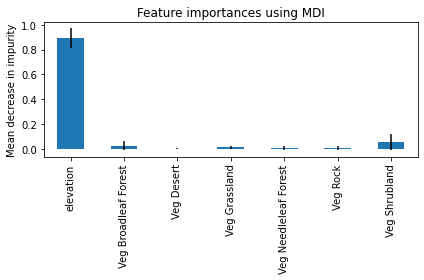

In [43]:
# based on mean decrease in impurity
importances = grid_searchRF.best_estimator_.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in grid_searchRF.best_estimator_.estimators_], axis=0)

forestImportances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots()
forestImportances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.savefig(fr"figures/{w_data.value}_corrMatrix.png")


### Gradient Boosted Trees (GBT)

In [40]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

param_grid = {'max_depth':[2,4,8,16,32,64,None], 'max_iter':[10, 50, 100, 250, 500, 1000, 2500]}

grid_searchGBT = GridSearchCV(HistGradientBoostingClassifier(), param_grid, cv=10, n_jobs=-1)
grid_searchGBT.fit(X_train, y_train)

print("Best parameters: {}".format(grid_searchGBT.best_params_))
print("Test set score: {}".format(grid_searchGBT.score(X_test, y_test)))

y_true, y_pred = y_test , grid_searchGBT.predict(X_test)
from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))

Best parameters: {'max_depth': None, 'max_iter': 1000}
Test set score: 0.6877852348993289
Results on the test set:
              precision    recall  f1-score   support

           0       0.55      0.52      0.54      1291
           1       0.75      0.78      0.76      2434

    accuracy                           0.69      3725
   macro avg       0.65      0.65      0.65      3725
weighted avg       0.68      0.69      0.69      3725



### Multi-Layered Perceptron (MLP)

In [36]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

# update hidden_layer_sizes (https://stackoverflow.com/a/10568938/14598178)
param_grid = {
    'hidden_layer_sizes': [(5), (50), (100), (250), (1000), (10, 10), (25, 25), (50, 50), (100, 100), (250, 250)],
    'activation': ['tanh', 'relu', 'logistic'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant']
}

grid_searchMLP = GridSearchCV(MLPClassifier(max_iter=10000), param_grid, cv=10, n_jobs=-1)

grid_searchMLP.fit(X_train, y_train)

print("Test set score: {}".format(grid_searchMLP.score(X_test, y_test)))

y_true, y_pred = y_test , grid_searchMLP.predict(X_test)
from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))

Test set score: 0.6877852348993289
Results on the test set:
              precision    recall  f1-score   support

           0       0.55      0.51      0.53      1291
           1       0.75      0.78      0.77      2434

    accuracy                           0.69      3725
   macro avg       0.65      0.65      0.65      3725
weighted avg       0.68      0.69      0.68      3725



Getting the final results (nicely formatted).

I wrote a function that does this since I couldn't find anything suitable online. Also saves it in a .csv file.

In [31]:
import re
from sklearn.metrics import precision_recall_fscore_support


def getResults(algoList, verbose=True, save=False):
    """
    :param algoList: List of gridSearch-class objects you want to get the results for
    :param verbose: If true prints the final Pandas dataframe
    :param save: If true saves the file as a .csv file in '/results/{dataset name}_results.csv'
    :return:
    """
    beforeParenthesis = re.compile("(.*?)\s*\(")

    dfResults = pd.DataFrame(columns=['Classifier', 'Parameters', 'Accuracy', 'Precision', 'Recall',
                                      'F1-Score', 'CV Splits', 'Training time'])
    for algo in algoList:
        tempList = []

        classifier = beforeParenthesis.match(str(algo.best_estimator_)).group(1)
        tempList.append(classifier)

        parameters = list(algo.best_params_.items())
        tempList.append(parameters)

        accuracy = algo.best_score_
        tempList.append(accuracy)

        y_true, y_pred = y_test, algo.predict(X_test)
        precision, recall, fScore, support = precision_recall_fscore_support(y_true, y_pred, average='macro')
        tempList.append(precision)
        tempList.append(recall)
        tempList.append(fScore)

        splits = algo.n_splits_
        tempList.append(splits)

        trainTime = algo.refit_time_
        tempList.append(trainTime)

        dfResults.loc[len(dfResults)] = tempList

    if save:
        dfResults.to_csv(fr'results/{w_data.value}_results.csv')

    if verbose:
        print(dfResults)

Now we call the function.

In [41]:
algoList = [grid_searchDummy, grid_searchKNN, grid_searchGNB, grid_searchSVC,
            grid_searchDT, grid_searchRF, grid_searchGBT, grid_searchMLP]

getResults(algoList, verbose=True, save=True)


                       Classifier  \
0                 DummyClassifier   
1            KNeighborsClassifier   
2                      GaussianNB   
3                             SVC   
4          DecisionTreeClassifier   
5          RandomForestClassifier   
6  HistGradientBoostingClassifier   
7                   MLPClassifier   

                                          Parameters  Accuracy  Precision  \
0                           [(strategy, stratified)]  0.499225   0.498586   
1            [(n_neighbors, 28), (weights, uniform)]  0.602212   0.597797   
2                                                 []  0.572948   0.622819   
3                         [(C, 0.25), (kernel, rbf)]  0.603202   0.650283   
4             [(criterion, entropy), (max_depth, 4)]  0.618566   0.669266   
5  [(criterion, gini), (max_depth, 4), (n_estimat...  0.623645   0.674979   
6              [(max_depth, None), (max_iter, 1000)]  0.632725   0.652845   
7  [(activation, logistic), (alpha, 0.0001), (hid.